In [26]:
%matplotlib inline
import pandas as pd
from glob import glob
import sys
import json
import os
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

from scipy.optimize import curve_fit

def samples_seen_from_str(samples):
    if samples.endswith("M"):
        samples = float(samples[:-1]) * 10**6
    elif samples.endswith("B"):
        samples = float(samples[:-1]) * 10**9
    elif samples.endswith("K"):
        samples = float(samples[:-1]) * 10**3
    return samples

def powlaw_irreducible(x, a, b, c):
    return a * np.power(x, b) + c


def powlaw_chinchilla(x, a, alpha, b, c):
    # x is tuple n, d
    return c + a * np.power(x[0], alpha) + b * np.power(x[1], alpha)

def powlaw(x, a, b):
    return a * np.power(x, b)


def curve_fit_powlaw_irreducible(xdata, ydata):
    # try many different fits and retain the best one as done in chinchilla
    a_p0 = [5e1, 5e2, 5e3]
    b_p0 = [-1e-1]
    c_p0 = [0.0]

    min_residual = float("inf")
    ret = None

    for a0 in a_p0:
        for b0 in b_p0:
            for c0 in c_p0:
                popt, pcov = curve_fit(
                    powlaw_irreducible,
                    xdata,
                    ydata,
                    p0=[a0, b0, c0],
                    maxfev=10000,
                )

                ydatafit = powlaw_irreducible(xdata, *popt)
                residuals = ydata - ydatafit
                curr_residual = (np.sum(residuals**2) / (residuals.size - 2)) ** 0.5

                if curr_residual < min_residual:
                    min_residual = curr_residual
                    ret = (popt, pcov, ydatafit)

    def func(x):
        a,b,c = ret[0]
        return (a*x**b+c)
    a,b,c = ret[0]
    return (a,b,c), func, f"Y = {a:.2f}*X^{b:.2f}+{c:.2f}"

def curve_fit_powlaw_quantile(xdata, ydata, q=0.1):
    from sklearn.linear_model import QuantileRegressor, LinearRegression
    if q is None:
        r = LinearRegression()
    else:
        r = QuantileRegressor(quantile=q, alpha=0, solver='highs-ds')
    print(r)
    log_xdata = np.log(xdata)
    log_ydata = np.log(ydata)
    r.fit(log_xdata.reshape((-1, 1)), log_ydata)
    def func(x):
        return (x**r.coef_[0]) * np.exp(r.intercept_)
    a, b = (r.intercept_, r.coef_[0])
    return (a,b), func, f"Y = {np.exp(a):.2f} x X^{b:.2f}"

In [37]:
model_profile = pd.read_csv("model_profile.csv").set_index("model")
df = pd.read_csv("results.csv")
df.head()

,model,pretrain_dataset,downstream_dataset,epoch,total_epochs,name,gflops_total,samples_per_sec,samples_per_sec_per_gpu,global_batch_size,training_time_hours,gpus,total_steps,task,namespace,eval_type,gpu_hours,image_acc,text_acc,acc,acc1,acc5,mean_per_class_recall,image_retrieval_recall@5,text_retrieval_recall@5,samples_seen_scale_simple,samples_seen_scale,lr,warmup,model_simple,name_wo_model,namespace_model,model_simple_namespace,namespace_model_samples_seen_scale,name_wo_lr,name_epoch
0,mammut_ViT-L-14,sugar,sugar_crepe/swap_obj,12,20,datacomp_s1.28B_bs_32768_mammut_ViT-L-14_ep20_lr0.0015_b1_0.9_b2_0.95_wd0.2_w20000_gc1_n32_bs256_sigFalse_consw0_cw1,2.685952e+11,16585.133257,129.571354,32768,21.438209,128,39062,generative_image_caption_selection,cap,log_likelihood,2744.090771,1.000,0.747967,0.747967,NaN,NaN,NaN,NaN,NaN,1.28B,1.28B,0.0015,20000,ViT-L-14,0.0015_1.28B_32768_20000,mammut_ViT-L-14_cap,ViT-L-14_cap,mammut_ViT-L-14_cap_1.28B,datacomp_s1.28B_bs_32768_mammut_ViT-L-14_ep20_b1_0.9_b2_0.95_wd0.2_w20000_gc1_n32_bs256_sigFalse_consw0_cw1,datacomp_s1.28B_bs_32768_mammut_ViT-L-14_ep20_lr0.0015_b1_0.9_b2_0.95_wd0.2_w20000_gc1_n32_bs256_sigFalse_consw0_cw112
1,mammut_ViT-L-14,winoground,winoground,10,20,datacomp_s1.28B_bs_32768_mammut_ViT-L-14_ep20_lr0.0015_b1_0.9_b2_0.95_wd0.2_w20000_gc1_n32_bs256_sigFalse_consw0_cw1,2.685952e+11,16585.133257,129.571354,32768,21.438209,128,39062,generative_image_caption_selection,cap,log_likelihood,2744.090771,0.125,0.157500,0.052500,NaN,NaN,NaN,NaN,NaN,1.28B,1.28B,0.0015,20000,ViT-L-14,0.0015_1.28B_32768_20000,mammut_ViT-L-14_cap,ViT-L-14_cap,mammut_ViT-L-14_cap_1.28B,datacomp_s1.28B_bs_32768_mammut_ViT-L-14_ep20_b1_0.9_b2_0.95_wd0.2_w20000_gc1_n32_bs256_sigFalse_consw0_cw1,datacomp_s1.28B_bs_32768_mammut_ViT-L-14_ep20_lr0.0015_b1_0.9_b2_0.95_wd0.2_w20000_gc1_n32_bs256_sigFalse_consw0_cw110
2,mammut_ViT-L-14,sugar,sugar_crepe/swap_obj,1,20,datacomp_s1.28B_bs_32768_mammut_ViT-L-14_ep20_lr0.0015_b1_0.9_b2_0.95_wd0.2_w20000_gc1_n32_bs256_sigFalse_consw0_cw1,2.685952e+11,16585.133257,129.571354,32768,21.438209,128,39062,generative_image_caption_selection,cap,log_likelihood,2744.090771,1.000,0.666667,0.666667,NaN,NaN,NaN,NaN,NaN,1.28B,1.28B,0.0015,20000,ViT-L-14,0.0015_1.28B_32768_20000,mammut_ViT-L-14_cap,ViT-L-14_cap,mammut_ViT-L-14_cap_1.28B,datacomp_s1.28B_bs_32768_mammut_ViT-L-14_ep20_b1_0.9_b2_0.95_wd0.2_w20000_gc1_n32_bs256_sigFalse_consw0_cw1,datacomp_s1.28B_bs_32768_mammut_ViT-L-14_ep20_lr0.0015_b1_0.9_b2_0.95_wd0.2_w20000_gc1_n32_bs256_sigFalse_consw0_cw11
3,mammut_ViT-L-14,sugar,sugar_crepe/replace_att,9,20,datacomp_s1.28B_bs_32768_mammut_ViT-L-14_ep20_lr0.0015_b1_0.9_b2_0.95_wd0.2_w20000_gc1_n32_bs256_sigFalse_consw0_cw1,2.685952e+11,16585.133257,129.571354,32768,21.438209,128,39062,generative_image_caption_selection,cap,log_likelihood,2744.090771,1.000,0.832487,0.832487,NaN,NaN,NaN,NaN,NaN,1.28B,1.28B,0.0015,20000,ViT-L-14,0.0015_1.28B_32768_20000,mammut_ViT-L-14_cap,ViT-L-14_cap,mammut_ViT-L-14_cap_1.28B,datacomp_s1.28B_bs_32768_mammut_ViT-L-14_ep20_b1_0.9_b2_0.95_wd0.2_w20000_gc1_n32_bs256_sigFalse_consw0_cw1,datacomp_s1.28B_bs_32768_mammut_ViT-L-14_ep20_lr0.0015_b1_0.9_b2_0.95_wd0.2_w20000_gc1_n32_bs256_sigFalse_consw0_cw19
4,mammut_ViT-L-14,sugar,sugar_crepe/replace_att,14,20,datacomp_s1.28B_bs_32768_mammut_ViT-L-14_ep20_lr0.0015_b1_0.9_b2_0.95_wd0.2_w20000_gc1_n32_bs256_sigFalse_consw0_cw1,2.685952e+11,16585.133257,129.571354,32768,21.438209,128,39062,generative_image_caption_selection,cap,log_likelihood,2744.090771,1.000,0.846447,0.846447,NaN,NaN,NaN,NaN,NaN,1.28B,1.28B,0.0015,20000,ViT-L-14,0.0015_1.28B_32768_20000,mammut_ViT-L-14_cap,ViT-L-14_cap,mammut_ViT-L-14_cap_1.28B,datacomp_s1.28B_bs_32768_mammut_ViT-L-14_ep20_b1_0.9_b2_0.95_wd0.2_w20000_gc1_n32_bs256_sigFalse_consw0_cw1,datacomp_s1.28B_bs_32768_mammut_ViT-L-14_ep20_lr0.0015_b1_0.9_b2_0.95_wd0.2_w20000_gc1_n32_bs256_sigFalse_consw0_cw114


In [38]:
model_profile

,image_size,image_width,text_width,embed_dim,mparams,image_mparams,text_mparams,gflops,image_gflops,text_gflops
model,,,,,,,,,,
ViT-S-32-alt,224,384.0,256.0,256.0,43.22,22.59,20.63,3.56,2.29,1.27
ViT-S-32,224,384.0,384.0,384.0,63.09,22.64,40.44,5.66,2.29,3.38
ViT-M-32-alt,224,512.0,384.0,384.0,80.07,39.63,40.44,7.37,3.99,3.38
ViT-M-32,224,512.0,512.0,512.0,103.12,39.69,63.43,9.95,3.99,5.96
ViT-S-16-alt,224,384.0,256.0,256.0,42.40,21.76,20.63,10.47,9.20,1.27
ViT-S-16,224,384.0,384.0,384.0,62.26,21.81,40.44,12.58,9.20,3.38
ViT-B-32,224,768.0,512.0,512.0,151.28,87.85,63.43,14.78,8.82,5.96
ViT-B-32-quickgelu,224,768.0,512.0,512.0,151.28,87.85,63.43,14.78,8.82,5.96
convnext_tiny,224,768.0,512.0,1024.0,92.30,28.61,63.69,14.87,8.91,5.96


In [44]:
d = df

#ds = 'sugar_crepe/swap_obj'
#ds = "winoground"
#metric = "acc"

ds = "imagenet1k"
metric = "acc1"

#eval_type = "log_likelihood"
#eval_type = "similarity"
d = d[d.downstream_dataset==ds]
d = d[d.epoch==d.total_epochs]
#d = d[d.eval_type == eval_type]
d = d.sort_values(by=metric, ascending=False)
vars=("samples_seen_scale_simple", "model_simple_namespace")
d = d.drop_duplicates(subset=vars, keep="first")
d = pd.pivot(
    d,
    index="samples_seen_scale_simple",
    columns=("model_simple_namespace"),
    values=metric,
)

cols = d.columns
cols = sorted(cols, key=lambda k:model_profile.loc["_".join(k.split("_")[:-1])].gflops)
d = d[cols]
index = sorted(d.index, key=lambda k:samples_seen_from_str(k))
d = d.loc[index]
d.T

samples_seen_scale_simple,1.28M,3M,6.4M,12.8M,30M,60.4M,128M,300M,640M,1.28B,3B,12.8B
model_simple_namespace,,,,,,,,,,,,
ViT-S-32_cap,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.305973,NaN,NaN
ViT-S-32_clip,0.01304,0.03032,NaN,0.10208,0.18664,NaN,0.35402,0.43956,NaN,0.531180,0.55864,NaN
ViT-S-32_coca,0.01512,0.03340,NaN,0.11228,0.20104,NaN,0.35774,0.43960,NaN,NaN,NaN,NaN
ViT-S-32_mammut,0.01452,0.03340,0.06400,0.11384,0.20358,0.29304,0.37228,0.45214,0.50264,0.514200,0.56516,NaN
ViT-M-32_cap,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.364715,NaN,NaN
ViT-M-32_clip,0.01396,0.03240,NaN,0.10504,0.20074,NaN,0.38302,0.47810,NaN,0.573040,0.60788,NaN
ViT-M-32_coca,0.01532,0.03114,NaN,0.11978,0.21860,NaN,0.38816,0.47972,NaN,NaN,NaN,NaN
ViT-M-32_mammut,0.01388,0.03344,0.06720,0.11964,0.22288,0.31810,0.40366,0.49076,0.55098,0.570700,0.61362,NaN
ViT-S-16_cap,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.351859,NaN,NaN


QuantileRegressor(alpha=0, quantile=0.01, solver='highs-ds')
QuantileRegressor(alpha=0, quantile=0.01, solver='highs-ds')
QuantileRegressor(alpha=0, quantile=0.01, solver='highs-ds')
QuantileRegressor(alpha=0, quantile=0.01, solver='highs-ds')
QuantileRegressor(alpha=0, quantile=0.01, solver='highs-ds')


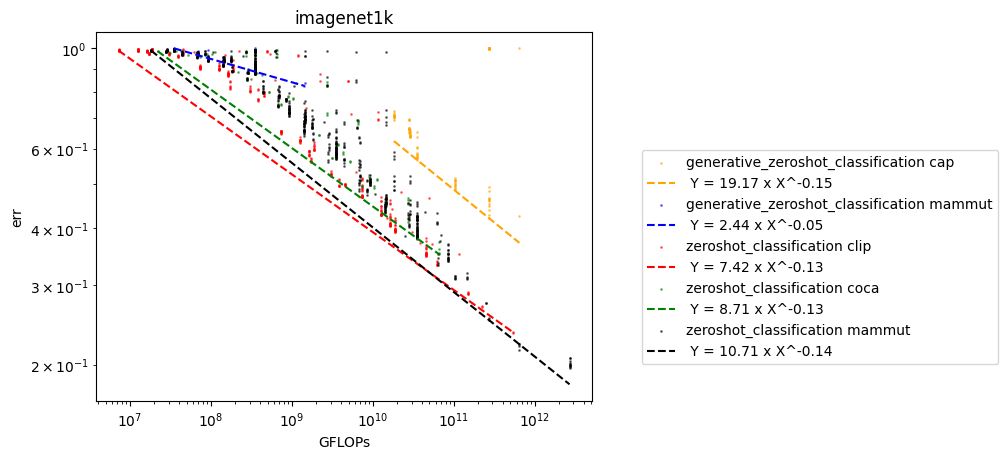

In [53]:
#s = "winoground"
#metric = "text_acc"

ds = "imagenet1k"
metric = "acc1"

D = df
D = D[D.epoch==D.total_epochs]
D = D[D.downstream_dataset==ds]
D = D[~D[metric].isna()]
colors = ["orange", "blue", "red", "green", "black"]
fig = plt.figure()
for ind, (name, rows) in enumerate(D.groupby(["task", "namespace"])):
    
    #if "generative" not in name[0]:
    #    continue
    R = rows[rows.downstream_dataset==ds]
    if len(R) == 0:
        continue
    #R = R[R[metric] >0.1]
    R = R.sort_values(by="gflops_total")
    X = (R["gflops_total"]).values
    Y = 1-(R[metric]).values
    color = colors[ind]
    plt.scatter(X, Y, label=f"{name[0]} {name[1]}", c=color, s=1.0, alpha=0.5)
    coefs, func, eq = curve_fit_powlaw_quantile(X, Y, q=0.01)
    plt.plot(X, func(X), label=f" {eq}", linestyle='dashed', c=color)

plt.xscale('log')
plt.yscale("log")
plt.xlabel("GFLOPs")
plt.ylabel("err")   
plt.title(ds)
plt.legend(loc=(1.1,.1))
plt.show()